## Предобработка данных

In [815]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os

width = os.get_terminal_size().columns
import plotly.express as px
from pandas.tseries.offsets import MonthEnd
import warnings
warnings.filterwarnings('ignore')

In [2]:
customers = pd.read_csv('customers.csv')
customers.head()

,id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord


In [3]:
orders = pd.read_csv('orders.csv')
orders.head()

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376


In [30]:
data = orders.merge(customers, how='left', left_on='customer_id', right_on='id')[['customer_id', 'id_x', 'order_date', 'ship_mode', 'sales', 'segment', 'state', 'city']]
data.columns = ['customer_id', 'order_id', 'order_date', 'ship_mode', 'sales', 'segment', 'state', 'city']
data['order_month'] = pd.to_datetime(data['order_date']).dt.to_period('M').dt.to_timestamp() + MonthEnd(1)

first_order_date = data[['customer_id', 'order_month']]
first_order_date['row_num'] = first_order_date.sort_values(by=['order_month']).groupby('customer_id').cumcount()+1
first_order_date = first_order_date[first_order_date['row_num'] == 1][['customer_id', 'order_month']]
first_order_date.columns = ['customer_id', 'first_order_month']
first_order_date.groupby('first_order_month').count().reset_index().head()

data = data.merge(first_order_date, how='left', on='customer_id')
data['MOB'] = data['order_month'].dt.to_period('M').astype('int') - data['first_order_month'].dt.to_period('M').astype('int')
data.head()

,customer_id,order_id,order_date,ship_mode,sales,segment,state,city,order_month,first_order_month,MOB
0,DK-13375,100006,2014-09-07,Standard,377.970,Consumer,Ohio,Marion,2014-09-30,2014-09-30,0
1,EB-13705,100090,2014-07-08,Standard,699.192,Corporate,Ohio,Akron,2014-07-31,2014-07-31,0
2,NF-18475,100293,2014-03-14,Standard,91.056,Home Office,Illinois,Rockford,2014-03-31,2014-03-31,0
3,JC-15340,100328,2014-01-28,Standard,3.928,Consumer,California,Los Angeles,2014-01-31,2014-01-31,0
4,JM-15655,100363,2014-04-08,Standard,21.376,Corporate,New Jersey,Bridgeton,2014-04-30,2014-04-30,0


In [185]:
monthly = pd.DataFrame()
monthly['test'] = pd.date_range(start=orders['order_date'].min(), end=orders['order_date'].max(), freq='M')

new_3 = pd.DataFrame(columns=['report_dt','customer_id','order_id','order_date','order_month', 'ship_mode', 'sales', 'segment', 'state', 'city', 'MOB', 'last_activity_dt', 'inactive_months'])
new_3

,report_dt,customer_id,order_id,order_date,order_month,ship_mode,sales,segment,state,city,MOB,last_activity_dt,inactive_months


In [ ]:
#Разметка базы по состояниям клиента

for i in customers['id']:
    print(i)
    con_test = data[data['customer_id'] == i]
    check = monthly.merge(con_test, how = 'left', left_on='test', right_on='order_month')
    check['status'] = np.select([(check['MOB'] == 0), (check['MOB'] > 0)], ['new', 'active'])
    
    last_activity_date = None
    inactive_months = 0
    status_set = None
    customer_id = None

    for index, row in check.iterrows():
        status = row['status']
        #print(status)
        if status == '0':
            pass
        else:
            status_set = status
            customer_id = row['customer_id']
            last_activity_date = row['order_month']
        #print(status_set)
        if status_set is not None:
            #print(row['customer_id'])
            if row['customer_id'] != customer_id:
                inactive_months += 1
                #print(inactive_months)
            else:
                inactive_months = 0
                last_activity_dt = row['order_month']

            new2 = pd.DataFrame([[row['test'],customer_id, row['order_id'], row['order_date'], row['order_month'], row['ship_mode'], row['sales'], row['segment'], row['state'], row['city'], row['MOB'], last_activity_dt, inactive_months]]
                                , columns=['report_dt','customer_id','order_id','order_date','order_month', 'ship_mode', 'sales', 'segment', 'state', 'city', 'MOB', 'last_activity_dt', 'inactive_months'])
            new_3 = pd.concat([new_3, new2])
    print(new_3.shape)

In [236]:
new_3.head()

,report_dt,customer_id,order_id,order_date,order_month,ship_mode,sales,segment,state,city,MOB,last_activity_dt,inactive_months,inactive_shift,client_status
0,2015-10-31,CG-12520,123918.0,2015-10-15,2015-10-31,Same Day,136.72,Consumer,Kentucky,Henderson,0.0,2015-10-31,0,NaN,0
0,2015-11-30,CG-12520,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31,1,0.0,0
0,2015-12-31,CG-12520,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31,2,1.0,0
0,2016-01-31,CG-12520,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31,3,2.0,0
0,2016-02-29,CG-12520,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31,4,3.0,0


In [216]:
marked_data = new_3.copy()

marked_data['inactive_shift'] = marked_data.groupby([['customer_id', 'report_dt']])['inactive_months'].shift(1)
marked_data['inactive_shift'] = marked_data['inactive_shift'].apply(lambda x: int(x) if x == x else x)
marked_data['inactive_months'] = marked_data['inactive_months'].apply(lambda x: int(x) if x == x else x)

marked_data['client_status'] = np.select([(marked_data['inactive_months'] == 0)&(marked_data['inactive_shift'] > 0)], ['reactivation'])

Видим, что в среднем люди реактивируются вне зависимости от сегмента через 6+ месяцев. Давайте будем считать отточным клиента, который находится без активности 7 и более месяцев

In [235]:
pd.DataFrame(round(marked_data[marked_data['client_status'] == 'reactivation'].groupby('segment').mean()['inactive_shift'],2))

,inactive_shift
segment,
Consumer,6.90
Corporate,6.77
Home Office,6.96


Проставим следующие статусы клиента:

- new - если клиент активен в первый раз
- active - если клиент активен или неактивен в течение 0-6м
- become churn - если клиент неактивен более, 7 месяцев (первый месяц оттока)
- remain churn - если клиент остается неактивным более, чем 7 месяцев
- reactivated - если клиент вернулся в активность из состояния become churn/remain churn


In [258]:
grouped_data = new_3.copy()
labeled_data = pd.DataFrame()

In [311]:
labeled_data['sales'] = grouped_data.groupby(['customer_id', 'report_dt']).sum().reset_index()[['sales']]
labeled_data = grouped_data.groupby(['customer_id', 'report_dt']).count().reset_index()[['customer_id', 'report_dt', 'order_id']]
labeled_data['sales'] = grouped_data.groupby(['customer_id', 'report_dt']).sum().reset_index()[['sales']]
labeled_data.columns = ['customer_id', 'report_dt', 'orders_cnt']

In [268]:
labeled_data['last_activity_dt'] = grouped_data.groupby(['customer_id', 'report_dt']).min().reset_index()['last_activity_dt']
labeled_data['inactive_months'] = grouped_data.groupby(['customer_id', 'report_dt']).min().reset_index()['inactive_months']
labeled_data['MOB'] = grouped_data.groupby(['customer_id', 'report_dt']).min().reset_index()['MOB']

In [278]:
labeled_data['inactive_shift'] = labeled_data.groupby(['customer_id'])['inactive_months'].shift(1)
labeled_data['inactive_shift'] = labeled_data['inactive_shift'].apply(lambda x: int(x) if x == x else x)
labeled_data['inactive_months'] = labeled_data['inactive_months'].apply(lambda x: int(x) if x == x else x)

labeled_data['client_status'] = np.select([(labeled_data['inactive_months'] == 0) & (labeled_data['inactive_shift'] > 0)], ['reactivation'])

In [297]:
labeled_data['client_status'] = np.select([(labeled_data['inactive_months'] == 7),
                                         (labeled_data['inactive_months']) > 7,
                                         ((labeled_data['inactive_months'] < 7) & (labeled_data['inactive_shift'] < 7)),
                                         ((labeled_data['inactive_months'] == 0) & (labeled_data['inactive_shift'] >= 7)),
                                         (labeled_data['MOB']==0)],
                                         
                                         ['become churn', 'remain churn', 'active', 'reactivated', 'new'])

In [385]:
labeled_data = labeled_data.merge(customers, how='left', left_on='customer_id', right_on='id')

In [518]:
labeled_data.head()

,customer_id,report_dt,orders_cnt,last_activity_dt,inactive_months,inactive_shift,client_status,MOB,sales,id,name,segment,state,city
0,AA-10315,2014-03-31,1,2014-03-31,0,NaN,new,0.0,726.548,AA-10315,Alex Avila,Consumer,Minnesota,Minneapolis
1,AA-10315,2014-04-30,0,2014-03-31,1,0.0,active,NaN,0.000,AA-10315,Alex Avila,Consumer,Minnesota,Minneapolis
2,AA-10315,2014-05-31,0,2014-03-31,2,1.0,active,NaN,0.000,AA-10315,Alex Avila,Consumer,Minnesota,Minneapolis
3,AA-10315,2014-06-30,0,2014-03-31,3,2.0,active,NaN,0.000,AA-10315,Alex Avila,Consumer,Minnesota,Minneapolis
4,AA-10315,2014-07-31,0,2014-03-31,4,3.0,active,NaN,0.000,AA-10315,Alex Avila,Consumer,Minnesota,Minneapolis


In [369]:
sales_by_date = labeled_data.groupby('report_dt').sum()['sales'].reset_index()
orders_cnt_by_date = labeled_data.groupby('report_dt').sum()['orders_cnt'].reset_index()

In [851]:
grouping_list =  ['report_dt', 'client_status', 'segment', 'state', 'city']
for_churn = labeled_data.groupby(grouping_list).count()['customer_id'].reset_index()
for_churn = for_churn.pivot_table('customer_id', ['report_dt', 'segment', 'state', 'city'], 'client_status').reset_index().rename_axis(None, axis=1)

grouping_list_2 = ['report_dt','segment', 'state', 'city']
sales_by_date = labeled_data.groupby(grouping_list_2).sum()['sales'].reset_index()
orders_cnt_by_date = labeled_data.groupby(grouping_list_2).sum()['orders_cnt'].reset_index()

for_churn = for_churn.merge(sales_by_date, how='left', on=grouping_list_2)
for_churn = for_churn.merge(orders_cnt_by_date, how='left', on=grouping_list_2)

for_churn.to_excel('for_churn.xlsx')
#for_churn = for_churn[for_churn['segment'] == 'Consumer']
#for_churn = for_churn.groupby('report_dt').sum().reset_index()

In [849]:
def get_graphs(for_churn, segment:str = None, state:str = None, city:str = None):
    if (segment is None) & (state is None) & (city is None):
        filtered_churn = for_churn.groupby('report_dt').sum().reset_index()
        text = 'Total'
    else:
        segment_filter = (lambda x: '' if x is None  else f"segment == '" + x + "'")(segment)
        state_filter = (lambda x: '' if x is None  else f"state == '" + x + "'")(state)
        city_filter = (lambda x: '' if x is None  else f"city == '" + x + "'")(city)
        
        text = ' ,'.join([x for x in [city, state, segment] if x is not None])
        r = ' & '.join([x for x in [city_filter, state_filter, segment_filter] if len(x)>0])
        filtered_churn = for_churn.query(r).groupby('report_dt').sum().reset_index()
    
    filtered_churn['active_shift'] = filtered_churn['active'].shift(1)
    filtered_churn['active_avg'] = (filtered_churn['active'] + filtered_churn['active_shift'])/2
    filtered_churn['churn_rate'] = filtered_churn['become churn']/filtered_churn['active_avg']
    filtered_churn['reactivation_rate'] = filtered_churn['reactivated']/filtered_churn['active_avg']
    filtered_churn['avg_order'] = filtered_churn['sales']/filtered_churn['orders_cnt']
    
    filtered_churn['year'] = filtered_churn['report_dt'].dt.year.astype('int')
    filtered_churn['churn'] = [1-i for i in filtered_churn['churn_rate']]
    filtered_churn['reactivation'] = [1-i for i in filtered_churn['reactivation_rate']]
    
    
    print('-------------ГОДОВАЯ ДИНАМИКА-------------')
    print('\n')
    test_1 = filtered_churn.groupby('year').prod()['churn'].reset_index()
    test_1['churn'] = (round(100-test_1['churn']*100,1)).astype('str') + '%'
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)
    
    test_1 = filtered_churn.groupby('year').prod()['reactivation'].reset_index()
    test_1['reactivation'] = round(100-test_1['reactivation']*100,1) .astype('str') + '%'
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)
    
    test_1 = filtered_churn.groupby('year').sum()['sales'].reset_index()
    test_1['sales'] = test_1['sales'].astype('int')
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)    
    
    test_1 = filtered_churn.groupby('year').sum()['orders_cnt'].reset_index()
    test_1['orders_cnt'] = test_1['orders_cnt'].astype('int')
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)    
    
    test_1 = filtered_churn.groupby('year').mean()['avg_order'].reset_index()
    test_1['avg_order'] = round(test_1['avg_order'],1)
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)    
    
    test_1 = filtered_churn.groupby('year').sum()['new'].reset_index()
    test_1['new'] = test_1['new'].astype('int')
    test_1 = test_1.T
    test_1.columns = test_1.iloc[0].astype('int')
    test_1 = test_1[1:]
    display(test_1)  
    
    print('\n')
    print('-------------МЕСЯЧНАЯ ДИНАМИКА-------------')
    print('\n')
    fig,ax = plt.subplots(3,2,figsize=(40,20))

    ax[0,0].plot(filtered_churn[['report_dt','churn_rate']].sort_values(by=['report_dt']).set_index('report_dt'))
    ax[0,0].set_title(f'Churn Rate, % for {text}')
    
    
    dates = filtered_churn['report_dt']
    data_test = filtered_churn['churn_rate']
    
    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = f'{round(y*100,1)}'
            ax[0,0].annotate(label,
                        (x, y),
                        textcoords="offset points",
                        xytext=(-1,-10),
                        ha='center')

    ax[0,1].plot(filtered_churn[['report_dt','reactivation_rate']].set_index('report_dt'))
    ax[0,1].set_title(f'Reactivation Rate, % for {text}')
    
    dates = filtered_churn['report_dt']
    data_test = filtered_churn['reactivation_rate']
    
    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = f'{round(y*100,1)}'
            ax[0,1].annotate(label,
                        (x, y),
                        textcoords="offset points",
                        xytext=(-1,-10),
                        ha='center')

    ax[1,0].plot(filtered_churn[['report_dt','sales']].set_index('report_dt'))
    ax[1,0].set_title(f"Sales Volume'000 for {text}")
    
    dates = filtered_churn['report_dt']
    data_test = filtered_churn['sales']
    
    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = int(y/1000)
            ax[1,0].annotate(label,
                        (x, y),
                        textcoords="offset points",
                        xytext=(-1,-10),
                        ha='center')

    ax[1,1].plot(filtered_churn[['report_dt','orders_cnt']].set_index('report_dt'))
    ax[1,1].set_title(f'Orders Count for {text}')
    
    dates = filtered_churn['report_dt']
    data_test = filtered_churn['orders_cnt']
    
    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = int(y)
            ax[1,1].annotate(label,
                        (x, y),
                        textcoords="offset points",
                        xytext=(-1,-10),
                        ha='center')

    ax[2,0].plot(filtered_churn[['report_dt','avg_order']].set_index('report_dt'))
    ax[2,0].set_title(f'Average Order for {text}')
    
    dates = filtered_churn['report_dt']
    data_test = filtered_churn['avg_order']
    
    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = int(y)
            ax[2,0].annotate(label,
                        (x, y),
                        textcoords="offset points",
                        xytext=(-1,-10),
                        ha='center')

    ax[2,1].plot(filtered_churn[['report_dt','new']].set_index('report_dt'))
    ax[2,1].set_title(f'New clients for {text}')
    
    dates = filtered_churn['report_dt']
    data_test = filtered_churn['new']
    
    for x, y in zip(dates, data_test):
        if y == 0:
            pass
        else:
            label = int(y)
            ax[2,1].annotate(label,
                        (x, y),
                        textcoords="offset points",
                        xytext=(-1,-10),
                        ha='center')
    plt.show()
    
    #return filtered_churn

-------------ГОДОВАЯ ДИНАМИКА-------------




year,2014,2015,2016,2017
churn,32.7%,73.3%,67.8%,57.7%


year,2014,2015,2016,2017
reactivation,7.4%,60.2%,68.5%,61.2%


year,2014,2015,2016,2017
sales,484247,470532,609205,649385


year,2014,2015,2016,2017
orders_cnt,969,1038,1315,1463


year,2014,2015,2016,2017
avg_order,470.2,453.6,464.0,450.5


year,2014,2015,2016,2017
new,595,136,51,11




-------------МЕСЯЧНАЯ ДИНАМИКА-------------




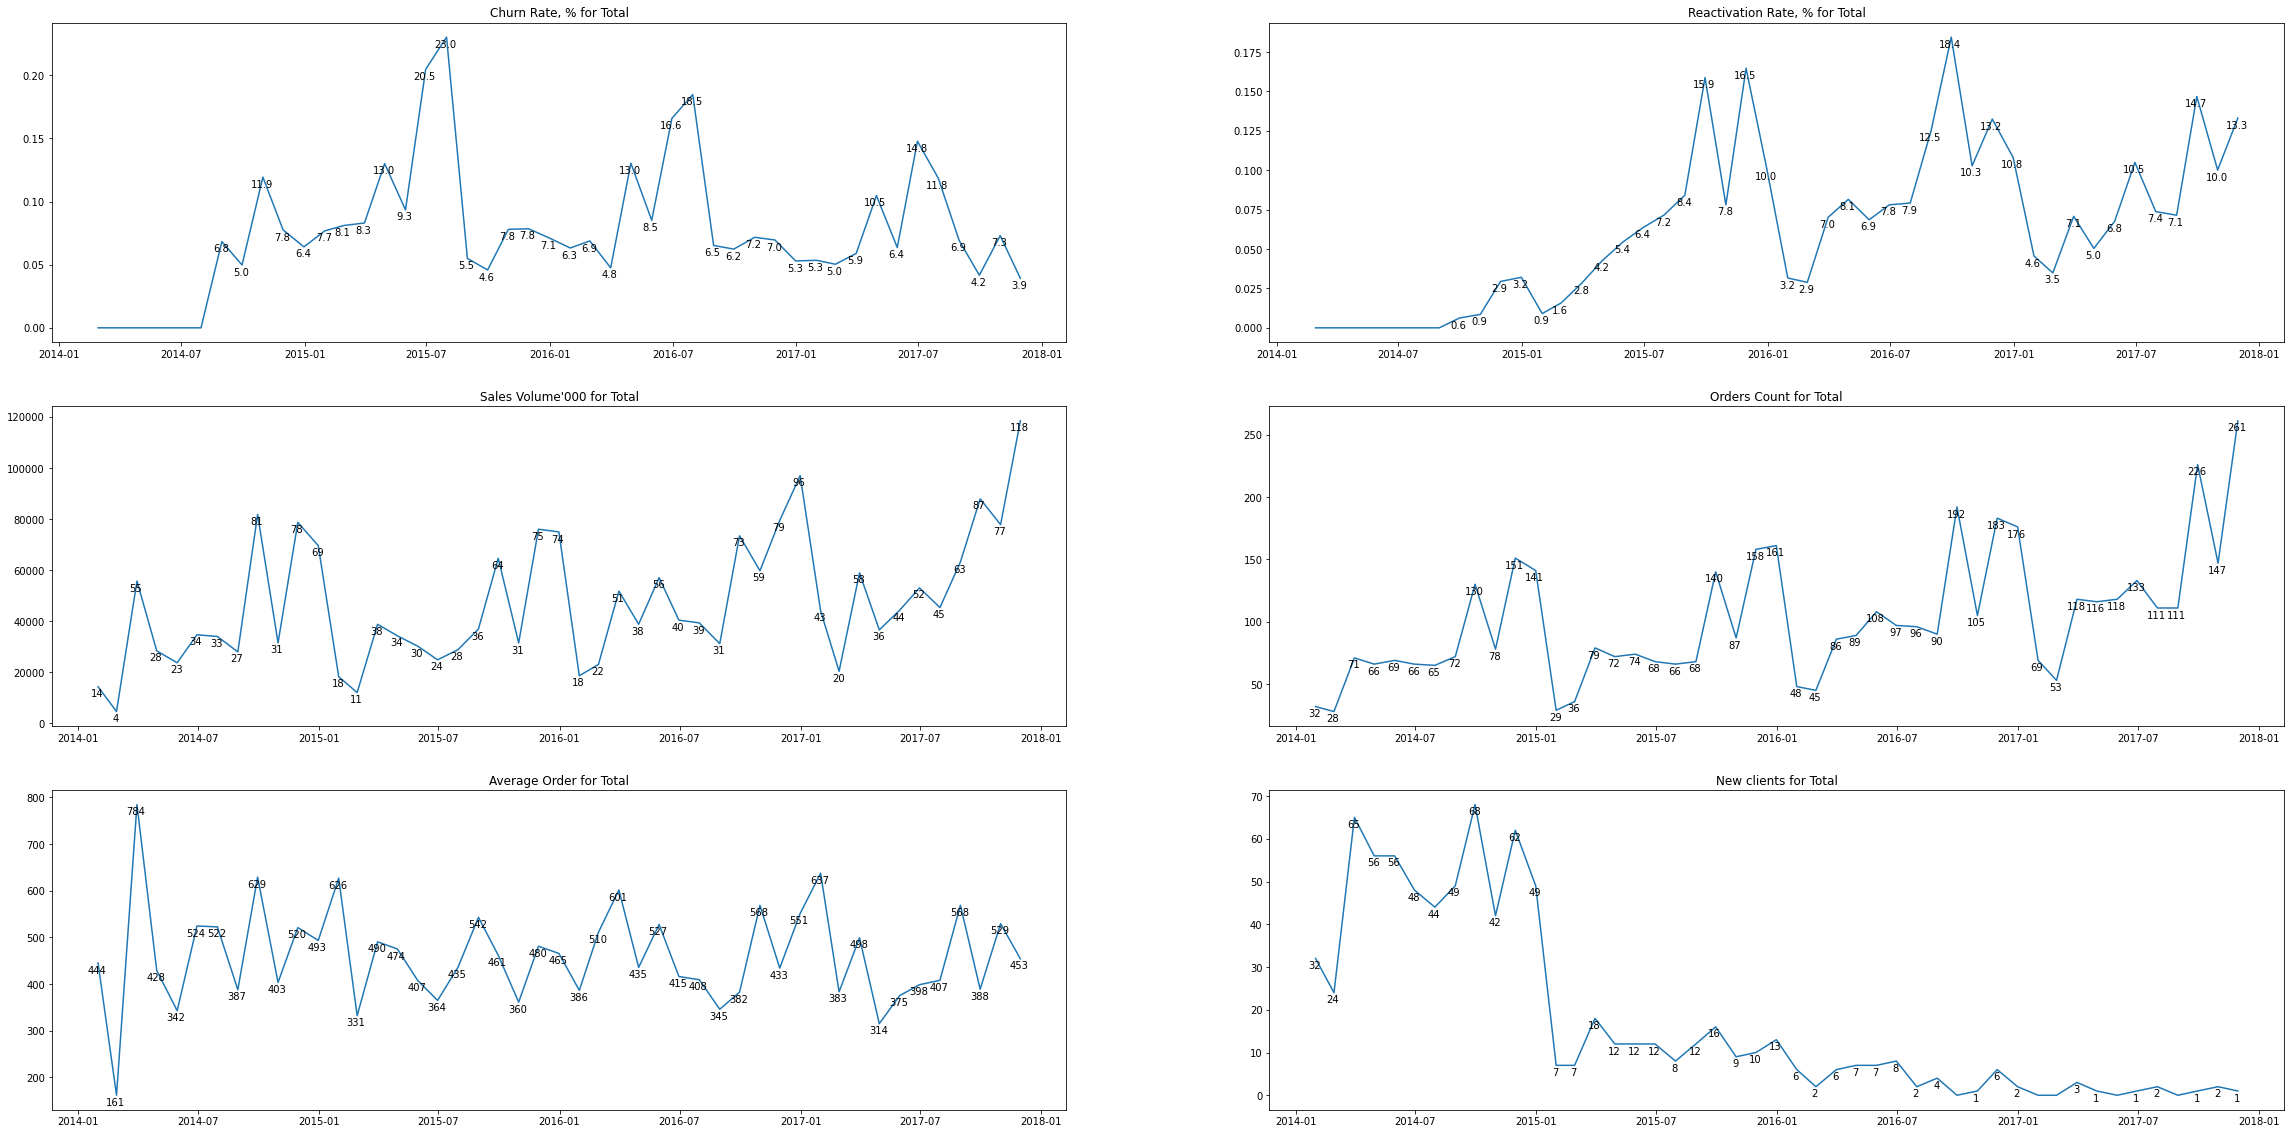

In [850]:
get_graphs(for_churn)
#get_graphs(segment = 'Consumer', state = 'Ohio')
#get_graphs(segment = 'Consumer')